#### This notebook trains our baseline model

Imports

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
os.chdir("../models")
from model import CustomCNN
from common_utils import set_seed, EarlyStopper, train, get_mean_rgb, CustomTransform, CustomRegularizeTransform

# set seed
set_seed(42)

Initialise model and dataset

In [2]:
model = CustomCNN(fcn_depth=4, fcn_width=[1024, 512, 256]) # initialise model

mean_rgb = get_mean_rgb(datasets.Flowers102(root='../data', split='test', download=True, transform=transforms.ToTensor()))

transform1 = transforms.Compose([
    # CustomRegularizeTransform(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Resize((100, 100), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_rgb, std=[1,1,1])
])

transform2 = transforms.Compose([
    # CustomRegularizeTransform(),
    transforms.Resize((100, 100), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_rgb, std=[1,1,1])
])

# load data
train_dataset = datasets.Flowers102(root='../data', split='test', download=True, transform=transform1) 
val_dataset = datasets.Flowers102(root='../data', split='val', download=True, transform=transform2) 
test_dataset = datasets.Flowers102(root='../data', split='train', download=True, transform=transform2)
# NOTE: Due to a bug with the Flowers102 dataset, the train and test splits are swapped

batch_size = 128
# initialise dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Specify hyperparameters

In [3]:
lr = 0.001 # learning rate
optimiser = torch.optim.Adam(model.parameters(), lr=lr) # initialise optimiser
loss = torch.nn.CrossEntropyLoss() # initialise loss function

if torch.cuda.is_available(): # nvidia gpu
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # apple gpu
    device = torch.device("mps")
else:
    device = torch.device("cpu")
model.to(device)

epochs = 300 # number of epochs
early_stopper = EarlyStopper(patience=10) # initialise early stopper


# Make directory to save baseline model
baseline_model_path = "./saved_models/baseline_model/non_preprocessed"
if not os.path.exists(baseline_model_path):
    os.makedirs(baseline_model_path, exist_ok=True)

# Define the device-specific path
device_type = None
if device == torch.device("cuda"):
    device_type = "cuda"
elif device == torch.device("mps"):
    device_type = "mps"
else:
    device_type = "cpu"

# Construct the full path
device_path = os.path.join(baseline_model_path, device_type)

# Create the directory if it doesn't exist
if not os.path.exists(device_path):
    os.mkdir(device_path)

model

CustomCNN(
  (conv_stack): Sequential(
    (0): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=3)
    (1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (2): ReLU()
    (3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=64)
    (7): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (8): ReLU()
    (9): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
    (13): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (14): ReLU()
  

Train the model

In [4]:
train_loss_list, val_loss_list, val_acc_list = train(model, train_dataloader, val_dataloader, optimiser, loss, device, epochs, early_stopper, device_path) # train model

Epoch 1/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:31<00:00,  1.55it/s, Training loss=4.0851]


Epoch 1/300 took 35.06s | Train loss: 4.0851 | Val loss: 5.4270 | Val accuracy: 1.96% | EarlyStopper count: 0


Epoch 2/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s, Training loss=3.4160]


Epoch 2/300 took 32.22s | Train loss: 3.4160 | Val loss: 5.9546 | Val accuracy: 1.37% | EarlyStopper count: 0


Epoch 3/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s, Training loss=2.9551]


Epoch 3/300 took 32.10s | Train loss: 2.9551 | Val loss: 3.5734 | Val accuracy: 12.16% | EarlyStopper count: 1


Epoch 4/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s, Training loss=2.6668]


Epoch 4/300 took 32.06s | Train loss: 2.6668 | Val loss: 2.8056 | Val accuracy: 27.55% | EarlyStopper count: 0


Epoch 5/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s, Training loss=2.6429]


Epoch 5/300 took 32.02s | Train loss: 2.6429 | Val loss: 2.7250 | Val accuracy: 29.31% | EarlyStopper count: 0


Epoch 6/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s, Training loss=2.3436]


Epoch 6/300 took 32.35s | Train loss: 2.3436 | Val loss: 2.4425 | Val accuracy: 34.31% | EarlyStopper count: 0


Epoch 7/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s, Training loss=2.1039]


Epoch 7/300 took 32.01s | Train loss: 2.1039 | Val loss: 2.1950 | Val accuracy: 39.12% | EarlyStopper count: 0


Epoch 8/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=1.9415]


Epoch 8/300 took 31.71s | Train loss: 1.9415 | Val loss: 2.0483 | Val accuracy: 44.61% | EarlyStopper count: 0


Epoch 9/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s, Training loss=1.7239]


Epoch 9/300 took 32.18s | Train loss: 1.7239 | Val loss: 2.0901 | Val accuracy: 44.22% | EarlyStopper count: 0


Epoch 10/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s, Training loss=1.6140]


Epoch 10/300 took 31.86s | Train loss: 1.6140 | Val loss: 1.9282 | Val accuracy: 46.47% | EarlyStopper count: 1


Epoch 11/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s, Training loss=1.4412]


Epoch 11/300 took 32.25s | Train loss: 1.4412 | Val loss: 2.2814 | Val accuracy: 39.90% | EarlyStopper count: 0


Epoch 12/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s, Training loss=2.6662]


Epoch 12/300 took 32.35s | Train loss: 2.6662 | Val loss: 2.4483 | Val accuracy: 36.37% | EarlyStopper count: 1


Epoch 13/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s, Training loss=2.2743]


Epoch 13/300 took 32.30s | Train loss: 2.2743 | Val loss: 2.1784 | Val accuracy: 39.90% | EarlyStopper count: 2


Epoch 14/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s, Training loss=2.0055]


Epoch 14/300 took 33.18s | Train loss: 2.0055 | Val loss: 2.1046 | Val accuracy: 41.76% | EarlyStopper count: 3


Epoch 15/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s, Training loss=1.8915]


Epoch 15/300 took 32.79s | Train loss: 1.8915 | Val loss: 1.9665 | Val accuracy: 45.20% | EarlyStopper count: 4


Epoch 16/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s, Training loss=1.6818]


Epoch 16/300 took 32.38s | Train loss: 1.6818 | Val loss: 1.8475 | Val accuracy: 48.82% | EarlyStopper count: 5


Epoch 17/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s, Training loss=1.6777]


Epoch 17/300 took 32.13s | Train loss: 1.6777 | Val loss: 1.9508 | Val accuracy: 45.98% | EarlyStopper count: 0


Epoch 18/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s, Training loss=1.6128]


Epoch 18/300 took 32.41s | Train loss: 1.6128 | Val loss: 1.8215 | Val accuracy: 49.41% | EarlyStopper count: 1


Epoch 19/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s, Training loss=1.5603]


Epoch 19/300 took 32.40s | Train loss: 1.5603 | Val loss: 1.7876 | Val accuracy: 50.49% | EarlyStopper count: 0


Epoch 20/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s, Training loss=1.4039]


Epoch 20/300 took 32.39s | Train loss: 1.4039 | Val loss: 1.7564 | Val accuracy: 50.88% | EarlyStopper count: 0


Epoch 21/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s, Training loss=1.3266]


Epoch 21/300 took 32.48s | Train loss: 1.3266 | Val loss: 1.7200 | Val accuracy: 52.94% | EarlyStopper count: 0


Epoch 22/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=1.2362]


Epoch 22/300 took 31.72s | Train loss: 1.2362 | Val loss: 1.7329 | Val accuracy: 52.06% | EarlyStopper count: 0


Epoch 23/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=1.1622]


Epoch 23/300 took 31.68s | Train loss: 1.1622 | Val loss: 1.6499 | Val accuracy: 54.22% | EarlyStopper count: 1


Epoch 24/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s, Training loss=1.0971]


Epoch 24/300 took 31.75s | Train loss: 1.0971 | Val loss: 1.6526 | Val accuracy: 55.20% | EarlyStopper count: 0


Epoch 25/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=1.0120]


Epoch 25/300 took 31.69s | Train loss: 1.0120 | Val loss: 1.7781 | Val accuracy: 52.94% | EarlyStopper count: 1


Epoch 26/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s, Training loss=1.2182]


Epoch 26/300 took 31.71s | Train loss: 1.2182 | Val loss: 1.7406 | Val accuracy: 54.22% | EarlyStopper count: 2


Epoch 27/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s, Training loss=1.0931]


Epoch 27/300 took 31.70s | Train loss: 1.0931 | Val loss: 1.6858 | Val accuracy: 54.71% | EarlyStopper count: 3


Epoch 28/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.75it/s, Training loss=0.9857]


Epoch 28/300 took 31.62s | Train loss: 0.9857 | Val loss: 1.6429 | Val accuracy: 55.39% | EarlyStopper count: 4


Epoch 29/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s, Training loss=0.9959]


Epoch 29/300 took 32.24s | Train loss: 0.9959 | Val loss: 1.6316 | Val accuracy: 55.39% | EarlyStopper count: 0


Epoch 30/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s, Training loss=0.9262]


Epoch 30/300 took 32.21s | Train loss: 0.9262 | Val loss: 1.6201 | Val accuracy: 56.57% | EarlyStopper count: 0


Epoch 31/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s, Training loss=0.9228]


Epoch 31/300 took 31.97s | Train loss: 0.9228 | Val loss: 1.7714 | Val accuracy: 55.88% | EarlyStopper count: 0


Epoch 32/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=0.8246]


Epoch 32/300 took 31.69s | Train loss: 0.8246 | Val loss: 1.8138 | Val accuracy: 55.00% | EarlyStopper count: 1


Epoch 33/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=0.8570]


Epoch 33/300 took 31.63s | Train loss: 0.8570 | Val loss: 1.7579 | Val accuracy: 55.88% | EarlyStopper count: 2


Epoch 34/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=1.1052]


Epoch 34/300 took 31.69s | Train loss: 1.1052 | Val loss: 1.8059 | Val accuracy: 54.51% | EarlyStopper count: 3


Epoch 35/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=0.9226]


Epoch 35/300 took 31.66s | Train loss: 0.9226 | Val loss: 1.5937 | Val accuracy: 57.45% | EarlyStopper count: 4


Epoch 36/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s, Training loss=0.8906]


Epoch 36/300 took 31.89s | Train loss: 0.8906 | Val loss: 1.7030 | Val accuracy: 57.35% | EarlyStopper count: 0


Epoch 37/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=0.8390]


Epoch 37/300 took 31.70s | Train loss: 0.8390 | Val loss: 1.6991 | Val accuracy: 57.55% | EarlyStopper count: 1


Epoch 38/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=0.7556]


Epoch 38/300 took 31.67s | Train loss: 0.7556 | Val loss: 1.7141 | Val accuracy: 57.84% | EarlyStopper count: 2


Epoch 39/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s, Training loss=0.7178]


Epoch 39/300 took 31.72s | Train loss: 0.7178 | Val loss: 1.8898 | Val accuracy: 55.00% | EarlyStopper count: 3


Epoch 40/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=2.0569]


Epoch 40/300 took 31.68s | Train loss: 2.0569 | Val loss: 2.0756 | Val accuracy: 49.41% | EarlyStopper count: 4


Epoch 41/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=1.3859]


Epoch 41/300 took 31.67s | Train loss: 1.3859 | Val loss: 1.7139 | Val accuracy: 55.20% | EarlyStopper count: 5


Epoch 42/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s, Training loss=1.4862]


Epoch 42/300 took 31.80s | Train loss: 1.4862 | Val loss: 2.0260 | Val accuracy: 47.65% | EarlyStopper count: 6


Epoch 43/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s, Training loss=2.5469]


Epoch 43/300 took 31.81s | Train loss: 2.5469 | Val loss: 2.2964 | Val accuracy: 39.22% | EarlyStopper count: 7


Epoch 44/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=1.9471]


Epoch 44/300 took 31.66s | Train loss: 1.9471 | Val loss: 2.3144 | Val accuracy: 39.51% | EarlyStopper count: 8


Epoch 45/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s, Training loss=3.3520]


Epoch 45/300 took 31.70s | Train loss: 3.3520 | Val loss: 2.8749 | Val accuracy: 25.98% | EarlyStopper count: 9
Early stopping


Plot train, test loss and test accuracy

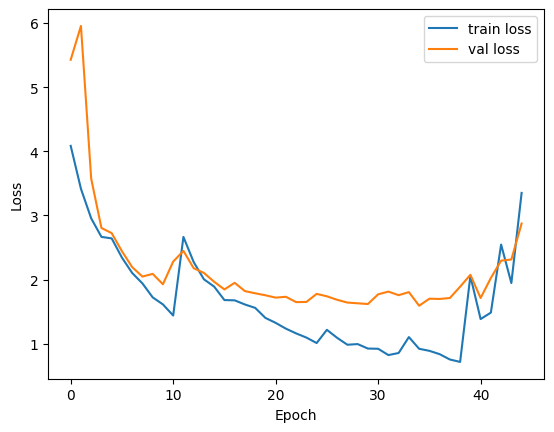

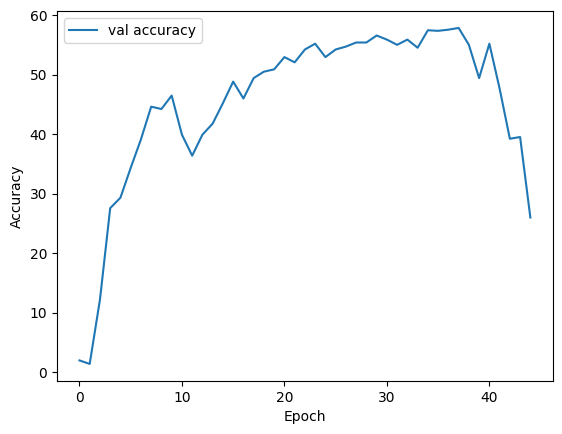

In [6]:
# plot the graphs
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(val_acc_list, label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()